In [73]:
%matplotlib inline
import pymongo
from pymongo import MongoClient
import matplotlib
matplotlib.rcParams.update({'font.size': 32,'image.cmap':'set3'})
import matplotlib.pyplot as plt
import numpy
from pprint import pprint
from collections import defaultdict, OrderedDict
from datetime import datetime, timedelta
from functools import partial
import time
import re
db = MongoClient('localhost').condor

In [106]:
db.condor_history.find_one({'LastRemoteHost': {'$regex':'wisc.edu'} })

{'BytesRecvd': 1892237.0,
 'BytesSent': 17056.0,
 'ClusterId': 14819626,
 'Cmd': '/scratch/simprod/glidein-gpu2/submit/12602/iceprod_7567.1480306314.784545/iceprod.12602.7567.clsim.sh',
 'CommittedTime': 13,
 'CompletionDate': 1480312804,
 'CumulativeSlotTime': 13.0,
 'DiskUsage_RAW': 614177,
 'EnteredCurrentStatus': 1480312804,
 'ExecutableSize_RAW': 3,
 'ExitBySignal': False,
 'ExitCode': 0,
 'ExitStatus': 0,
 'GlobalJobId': 'glidein-simprod.icecube.wisc.edu#14819626.0#1480306712',
 'ImageSize_RAW': 120428,
 'JobCurrentStartDate': 1480312791,
 'JobStartDate': 1480312791,
 'JobStatus': 4,
 'LastJobStatus': 2,
 'LastRemoteHost': 'slot1@17297@gtx-12.icecube.wisc.edu',
 'MATCH_EXP_JOBGLIDEIN_ResourceName': 'xsede-osg',
 'NumJobStarts': 1,
 'NumShadowStarts': 1,
 'Owner': 'juancarlos',
 'ProcId': 0,
 'QDate': 1480306712,
 'RemoteSysCpu': 0.0,
 'RemoteUserCpu': 0.0,
 'RemoteWallClockTime': 13.0,
 'RequestCpus': 1,
 'RequestDisk': 4000000,
 'RequestMemory': 3000,
 'Requestgpus': 1,
 'Reside

In [48]:
start_time = time.time()
pipeline = [
    {'$match':{'MATCH_EXP_JOBGLIDEIN_ResourceName':{'$exists': True}}},
    {'$group':{'_id':'$MATCH_EXP_JOBGLIDEIN_ResourceName','count':{'$sum':1}}}
]
groups = {row['_id']:row['count'] for row in db.condor_history.aggregate(pipeline)}
print(time.time()-start_time)
pprint(len(groups))

70.22745156288147
1310


In [5]:
groups2 = {k:groups[k] for k in groups if '.' not in k and not k.startswith('gzk')}
pprint(len(groups2))
pprint(groups2)

63
{'AGLT2': 237380,
 'BEgrid-ULB-VUB': 215871,
 'BNL-ATLAS': 539733,
 'Bartol': 535550,
 'Bridges': 165776,
 'CA-MCGILL-CLUMEQ-T2': 742418,
 'CA-SCINET-T2': 1152662,
 'CHTC': 11196722,
 'CIT_CMS_T2': 1591568,
 'Clemson-Palmetto': 202124,
 'Comet': 3030947,
 'Crane': 1571323,
 'DESY': 2476589,
 'DESY-HH': 88672,
 'DESY-ZN': 4145524,
 'Dourtmund': 1,
 'FLTECH': 82062,
 'GPGrid': 977499,
 'GZK': 8036,
 'GridUNESP_CENTRAL': 82944,
 'Guillimin': 3215929,
 'HOSTED_STANFORD': 679328,
 'Hyak': 1338660,
 'IceCube_DE_Dortmund_udo-ce08': 5,
 'LIDO_Dortmund': 181590,
 'Local Job': 4756781,
 'MWT2': 999292,
 'NPX': 1447528,
 'NUMEP-OSG': 67533,
 'NWICG_NDCMS': 383681,
 'NYSGRID_CORNELL_NYS1': 59258,
 'Nebraska': 1103446,
 'OU_OSCER_ATLAS': 115324,
 'PHIDO_Dortmund': 62922,
 'Purdue-Hadoop': 298535,
 'RWTH-Aachen': 298206,
 'SPRACE': 531590,
 'SU-OG': 358206,
 'SU-OG-CE': 1500282,
 'SU-OG-CE1': 913974,
 'SWT2_CPB': 35003,
 'Sandhills': 60213,
 'T2B_BE_IIHE': 3217864,
 'Tusker': 748472,
 'UCD': 2061

In [88]:
datetime.fromtimestamp(1480357355)

datetime.datetime(2016, 11, 28, 12, 22, 35)

In [199]:
def timekey(t):
    return datetime.fromtimestamp(t).strftime('%Y-%m-%d')
def make2list():
    return [0.,0.]                              
def make3list():
    return [0.,0.,0]                     

In [66]:
time.mktime((2017,1,0,0,0,0,0,0,0))

1483164000.0

In [213]:
projection = ['MATCH_EXP_JOBGLIDEIN_ResourceName','EnteredCurrentStatus',
              'RemoteWallClockTime','CumulativeSlotTime','NumJobStarts',
              'ExitCode','ExitBySignal','ExitSignal','JobStatus','LastJobStatus',
              'LastHoldReason',]
filter = {'EnteredCurrentStatus':{'$gte':time.mktime((2017,2,1,0,0,0,0,0,0)),
                                  '$lt':time.mktime((2017,3,1,0,0,0,0,0,0))},
          'LastRemoteHost':{'$regex':'glidein_'},
          #'LastRemoteHost':{'$not': re.compile('glidein_') },
          #'Requestgpus':0,
          #'MATCH_EXP_JOBGLIDEIN_ResourceName':{'$nin':['NPX','GZK','WIPAC','CHTC']},
          #'LastRemoteHost':{'$not': re.compile('gzk') },
         }
# by day
good_completed = defaultdict(partial(defaultdict,make2list))
bad_completed = defaultdict(partial(defaultdict,make2list))
bad_removed_run = defaultdict(partial(defaultdict,make2list))
bad_removed_hold_memory = defaultdict(partial(defaultdict,make2list))
bad_removed_hold_transfer = defaultdict(partial(defaultdict,make2list))
bad_removed_hold = defaultdict(partial(defaultdict,make2list))
bad_removed_other = defaultdict(partial(defaultdict,make2list))
bad_signal = defaultdict(partial(defaultdict,make2list))
bad_signal_glidein = defaultdict(partial(defaultdict,make2list))
bad_signal_user = defaultdict(partial(defaultdict,make2list))
bad_restarts = defaultdict(make3list)
no_restarts = defaultdict(partial(defaultdict,int))
start_time = time.time()
for i,row in enumerate(db.condor_history.find(filter=filter,projection=projection)):
    try:
        if 'MATCH_EXP_JOBGLIDEIN_ResourceName' not in row:
            continue
        site = row['MATCH_EXP_JOBGLIDEIN_ResourceName']
        #if site not in ('CHTC','HEP') and 'WISC' not in site:
        #    continue
        date = timekey(row['EnteredCurrentStatus'])
        if not row['ExitBySignal']:
            if row['JobStatus'] == 4:
                if row['ExitCode'] == 0:
                    good_completed[site][date][0] += float(row['RemoteWallClockTime'])
                    good_completed[site][date][1] += 1
                else:
                    bad_completed[site][date][0] += float(row['RemoteWallClockTime'])
                    bad_completed[site][date][1] += 1
            elif row['JobStatus'] == 3:
                if row['LastJobStatus'] == 2:
                    bad_removed_run[site][date][0] += float(row['RemoteWallClockTime'])
                    bad_removed_run[site][date][1] += 1
                elif row['LastJobStatus'] == 5:
                    if 'LastHoldReason' in row and 'memory' in row['LastHoldReason'].lower():                        
                        bad_removed_hold_memory[site][date][0] += float(row['RemoteWallClockTime'])
                        bad_removed_hold_memory[site][date][1] += 1
                    elif 'LastHoldReason' in row and 'failed to receive' in row['LastHoldReason'].lower():                        
                        bad_removed_hold_transfer[site][date][0] += float(row['RemoteWallClockTime'])
                        bad_removed_hold_transfer[site][date][1] += 1
                    else:
                        bad_removed_hold[site][date][0] += float(row['RemoteWallClockTime'])
                        bad_removed_hold[site][date][1] += 1
                else:
                    bad_removed_other[site][date][0] += float(row['RemoteWallClockTime'])
                    bad_removed_other[site][date][1] += 1
        else:
            if row['ExitSignal'] in (6,11,7,8):
                bad_signal_user[site][date][0] += float(row['RemoteWallClockTime'])
                bad_signal_user[site][date][1] += 1
            elif row['ExitSignal'] in (12,9,15):
                bad_signal_glidein[site][date][0] += float(row['RemoteWallClockTime'])
                bad_signal_glidein[site][date][1] += 1
            else:
                bad_signal[site][date][0] += float(row['RemoteWallClockTime'])
                bad_signal[site][date][1] += 1
        
        if row['NumJobStarts'] > 1:
            bad_restarts[date][0] += float(row['CumulativeSlotTime'])-float(row['RemoteWallClockTime'])
            bad_restarts[date][1] += 1
            bad_restarts[date][2] += int(row['NumJobStarts'])
        else:
            no_restarts[site][date] += 1
    except:
        print(row)
        raise
print(time.time()-start_time)

7.680648565292358


In [214]:
bad_all = defaultdict(partial(defaultdict,make2list))
bad_by_type = defaultdict(partial(defaultdict,make2list))
bad_categories = OrderedDict([
        ('Completed - Exit != 0', bad_completed),
        ('Removed', bad_removed_run),
        ('Hold Memory', bad_removed_hold_memory),
        ('Hold Transfer', bad_removed_hold_transfer),
        ('Hold Other', bad_removed_hold),
        ('Removed Other', bad_removed_other),
        ('User SIGSEGV', bad_signal_user),
        ('Glidein Walltime', bad_signal_glidein),
        ('Signal Other', bad_signal),
])

for name,cat in bad_categories.items():
    for k in cat:
        for d in cat[k]:
            bad_all[k][d][0] += cat[k][d][0]
            bad_all[k][d][1] += cat[k][d][1]
            bad_by_type[name][d][0] += cat[k][d][0]
            bad_by_type[name][d][0] += cat[k][d][1]

In [215]:
print(good_completed.keys())
print(len(colors))

dict_keys(['SU-OG-CE', 'UCSDT2', 'NPX', 'SPRACE', 'CIT_CMS_T2', 'Hyak', 'SWT2_CPB', 'Tusker', 'AGLT2', 'Sandhills', 'Nebraska', 'MWT2', 'Clemson-Palmetto', 'UConn-OSG', 'HOSTED_STANFORD', 'Crane', 'UTA_SWT2', 'USCMS-FNAL-WC1', 'BNL-ATLAS', 'SU-OG-CE1', 'GPGrid', 'FLTECH', 'GridUNESP_CENTRAL'])
12


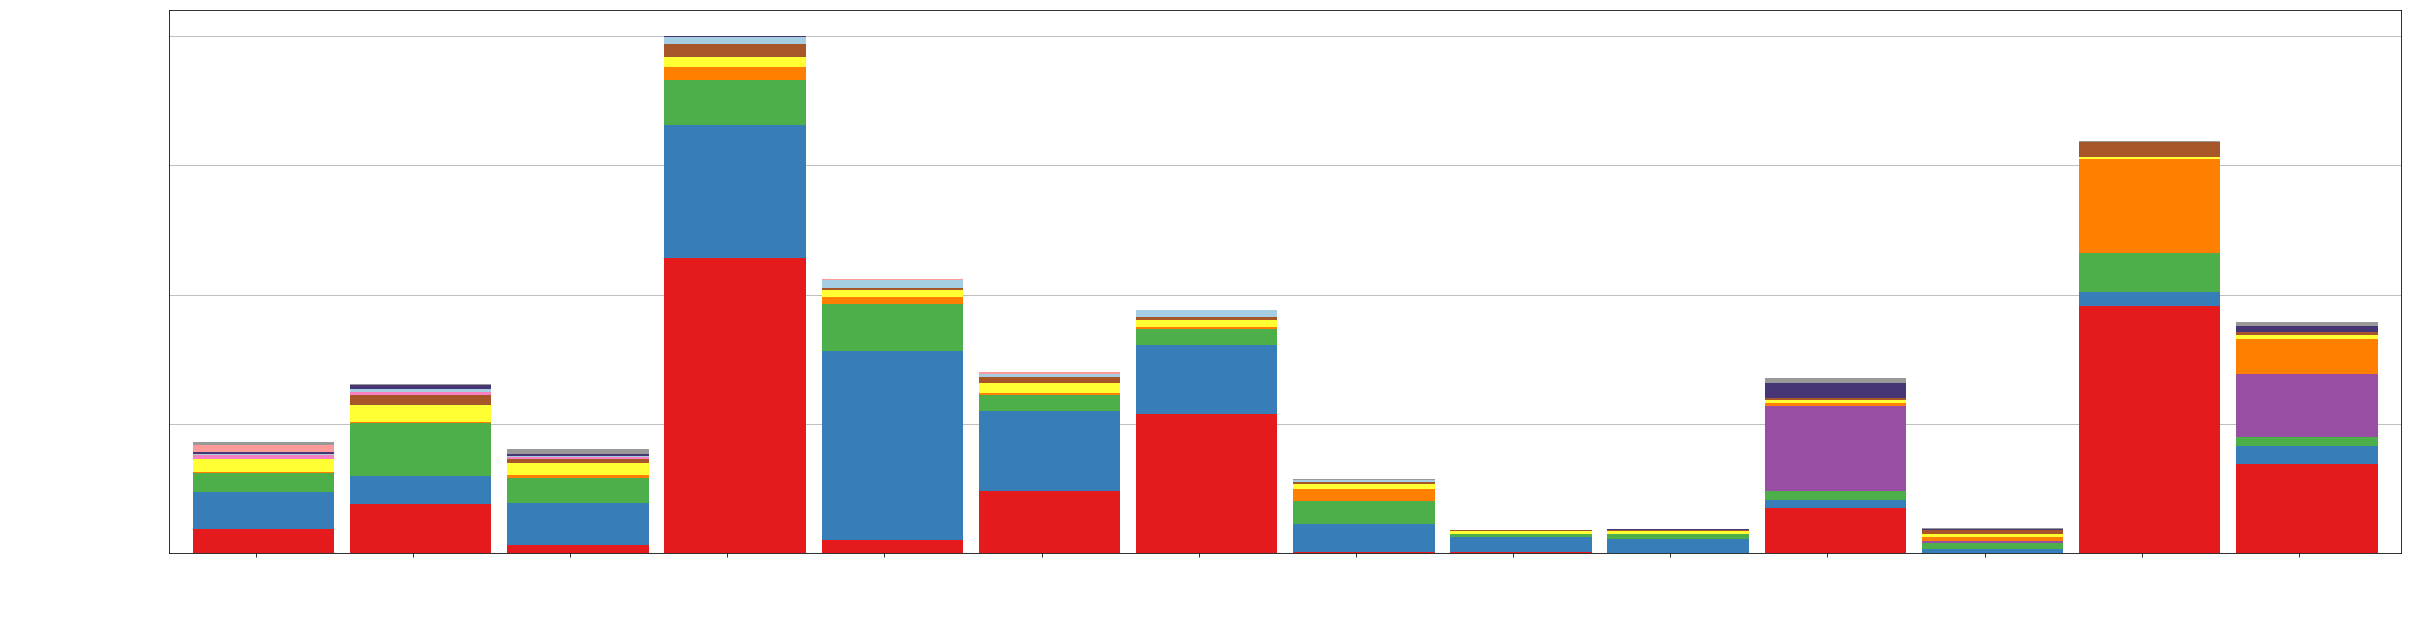

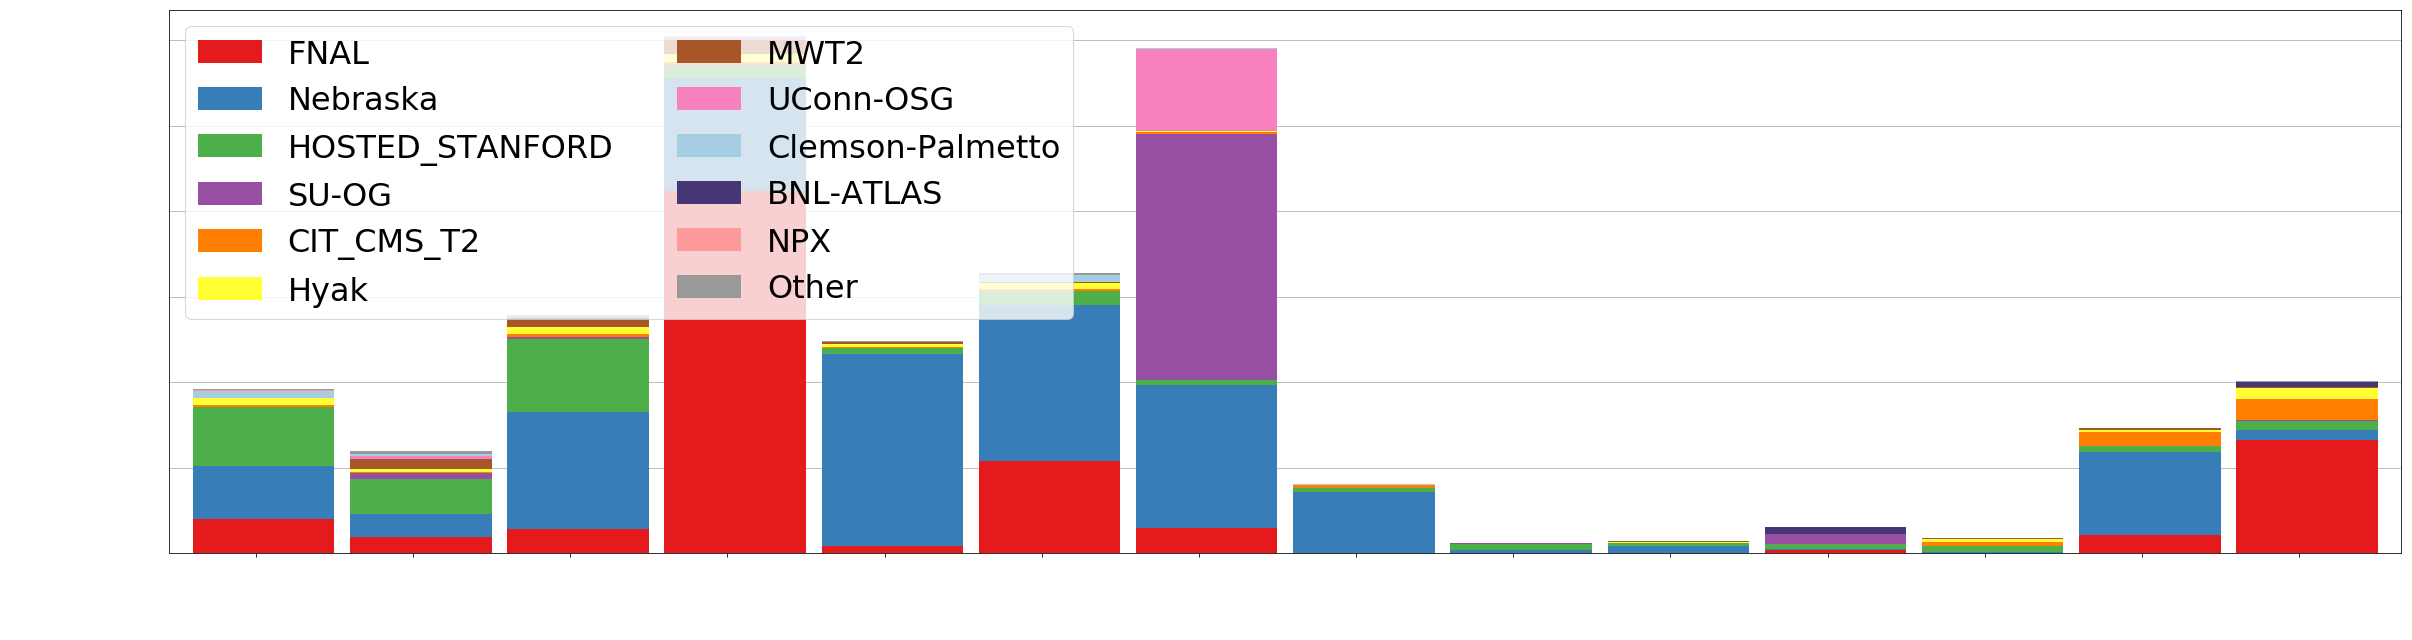

In [216]:
categories = OrderedDict([
    ('Goodput', good_completed),
    ('Badput', bad_all),
])
colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf','#a6cee3','#463676','#fb9a99','#999999',]
all_time_sites = defaultdict(float)
for category in categories.values():
    for k,new_k in [('CA-MCGILL-CLUMEQ-T2','Guillimin'),
                    ('parallel','Alberta'),
                    ('Sandhills','Nebraska'),
                    ('Tusker','Nebraska'),
                    ('Crane','Nebraska'),
                    ('SU-OG-CE','SU-OG'),
                    ('SU-OG-CE1','SU-OG'),
                    ('SU-OG-CE2','SU-OG'),
                    ('jasper','Alberta'),
                    ('CA-SCINET-T2','CA-Toronto'),
                    ('Guillimin','CA-McGill'),
                    ('T2B_BE_IIHE','IIHE'),
                    ('DESY-ZN','DESY'),
                    ('DESY-HH','DESY'),
                    ('GPGrid','FNAL'),
                    ('USCMS-FNAL-WC1','FNAL'),
                    ('IceCube_DE_Dortmund_udo-ce08','Dortmund'),
                    ('UNI-DORTMUND','Dortmund'),
                    ('LIDO_Dortmund','Dortmund'),
                    ('wuppertalprod','Wuppertal'),
                    #('Comet','UCSDT2'),
                    ('mainzgrid','Mainz'),
                    ('mainz','Mainz'),
                    ('Mainz','IceCube-Mainz'),
                    ('Dortmund','IceCube-Dortmund'),
                    ('DESY','IceCube-DESY'),
                    ('CA-Toronto','IceCube-CA-Toronto'),
                    ('CA-McGill','IceCube-CA-McGill'),
                    ('Wuppertal','IceCube-Wuppertal'),
                    ('RWTH-Aachen','IceCube-Aachen'),
                    ('BEgrid-ULB-VUB','IceCube-Brussels'),
                    ('IIHE','IceCube-IIHE'),
                    ('Comet','XSEDE-Comet'),
                    ('xsede-osg','XSEDE-OSG'),
                    ('WISC','OTHER_WISC'),
                   ]:
        for d in category[k]:
            category[new_k][d][0] += category[k][d][0]
            category[new_k][d][1] += category[k][d][1]
        del category[k]
    for site in category:
        all_time_sites[site] += sum(category[site][d][0] for d in category[site])
top10 = sorted(all_time_sites,key=lambda k:all_time_sites[k],reverse=True)[:11]+['Other']
top10 = sorted(top10,key=lambda k:(100000 if 'IceCube' in k else 1)*all_time_sites[k],reverse=True)
top10 = OrderedDict((t,c) for t,c in zip(top10,colors))

for title,category in categories.items():
    x = sorted(set(x for k in category for x in category[k].keys()))
    xx = numpy.arange(len(x))
    y = {k:numpy.array([category[k][d][0]/3600 for d in x]) for k in category}
    #pprint(y.keys())
    other = numpy.sum([y[k] for k in y if k not in top10], axis=0)

    legend = [k for k in top10 if k in y]
    if other.any():
        legend.append('Other')
    width = .9
    plots = []
    fig, ax = plt.subplots(figsize=(40, 10))
    #ax.set_title(title,color='white')
    ax.set_xticks(xx-.05)
    ax.set_xticklabels(x, color='white')
    ax.get_yaxis().set_tick_params(colors='white')
    #ax.set_xlabel('Month', labelpad=10, color='white', fontsize=44)
    ax.set_ylabel('CPUhours', labelpad=10, color='white', fontsize=44)
    ax.get_yaxis().grid(b=True, which='major')
    ax.set_axisbelow(True)
    bottom = numpy.zeros(len(x))
    for i,k in enumerate(legend):
        if k == 'Other':
            plots.append(ax.bar(xx, other, width, bottom=bottom, color=top10[k]))
            bottom += other
        else:
            plots.append(ax.bar(xx, y[k], width, bottom=bottom, color=top10[k]))
            bottom += y[k]
    labels = ax.get_xticklabels()
    plt.setp(labels, rotation=45, fontsize=15, horizontalalignment='right')
    plt.xlim([-.6,len(xx)-.4])
    #plt.ylim([0,400000])
    if title != 'Goodput':
        plt.legend(plots, legend, loc='upper left', ncol=2)

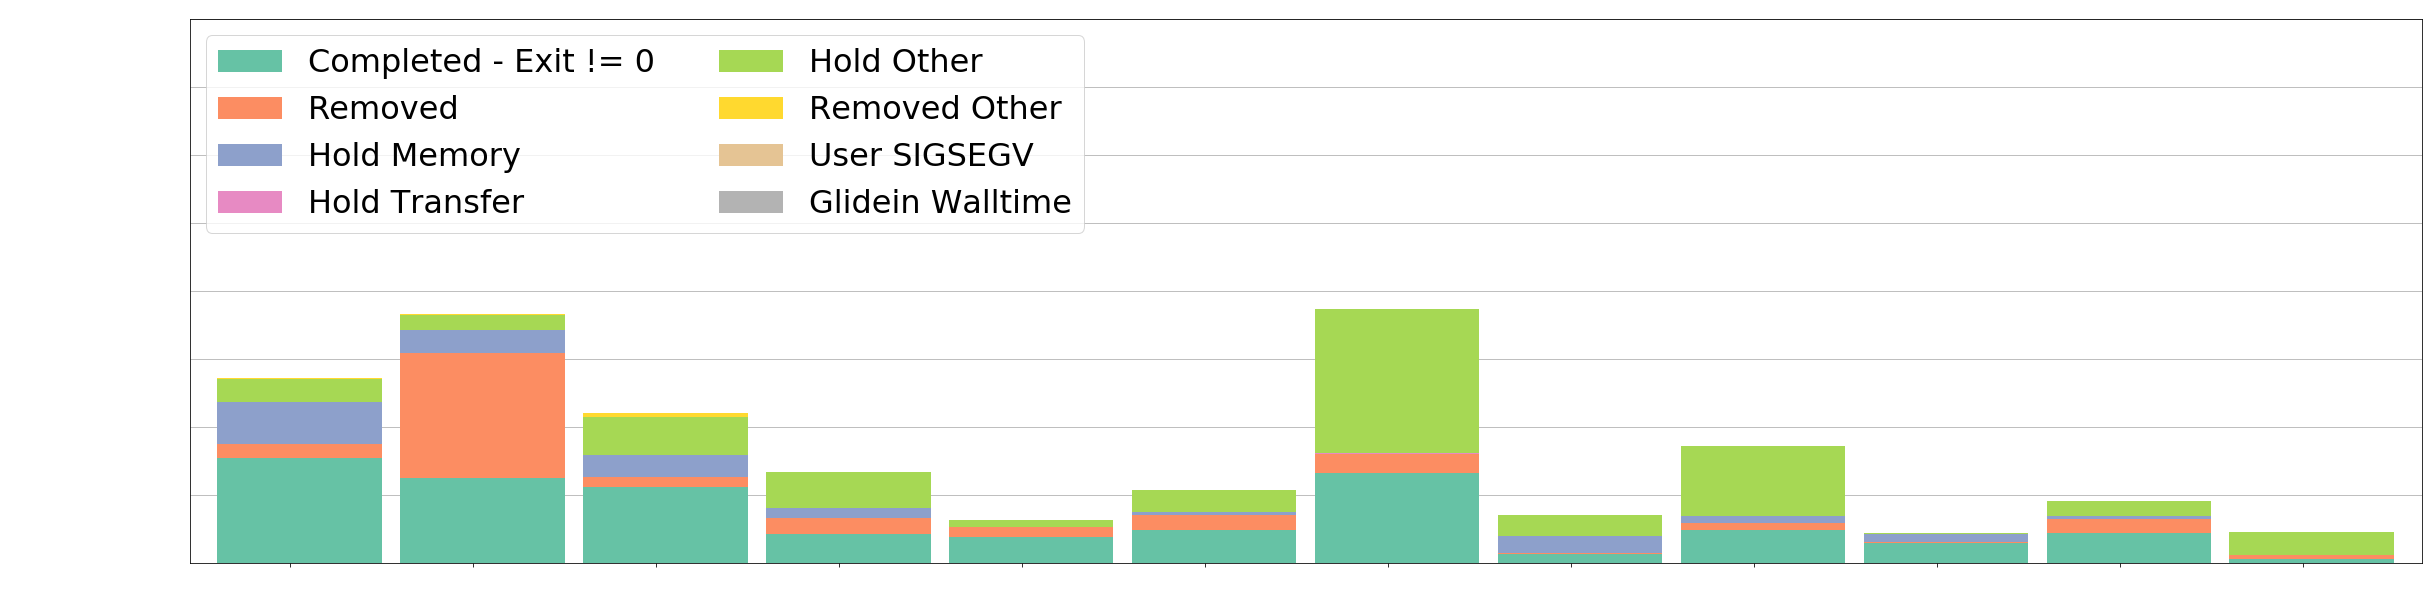

In [193]:
categories = OrderedDict([
    ('Bad by type', bad_by_type),
])
colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494','#b3b3b3']
all_time_sites = defaultdict(float)
for category in categories.values():
    for site in category:
        all_time_sites[site] += sum(category[site][d][0] for d in category[site])
top10 = bad_categories.keys()
top10 = OrderedDict((t,c) for t,c in zip(top10,colors))

for title,category in categories.items():
    x = sorted(set(x for k in category for x in category[k].keys()))
    xx = numpy.arange(len(x))
    y = {k:numpy.array([category[k][d][0]/3600 for d in x]) for k in category}

    legend = [k for k in top10 if k in y]
    width = .9
    plots = []
    fig, ax = plt.subplots(figsize=(40, 10))
    #ax.set_title(title,color='white')
    ax.set_xticks(xx-.05)
    ax.set_xticklabels(x, color='white')
    ax.get_yaxis().set_tick_params(colors='white')
    #ax.set_xlabel('Month', labelpad=10, color='white', fontsize=44)
    ax.set_ylabel('CPUhours', labelpad=10, color='white', fontsize=44)
    ax.get_yaxis().grid(b=True, which='major')
    ax.set_axisbelow(True)
    bottom = numpy.zeros(len(x))
    for i,k in enumerate(legend):
        if k == 'Other':
            plots.append(ax.bar(xx, other, width, bottom=bottom, color=top10[k]))
            bottom += other
        else:
            plots.append(ax.bar(xx, y[k], width, bottom=bottom, color=top10[k]))
            bottom += y[k]
    #labels = ax.get_xticklabels()
    #plt.setp(labels, rotation=45, fontsize=15, horizontalalignment='right')
    plt.xlim([-.6,len(xx)-.4])
    plt.ylim([0,400000])
    plt.legend(plots, legend, ncol=2, loc='upper left')

(-0.6, 11.6)

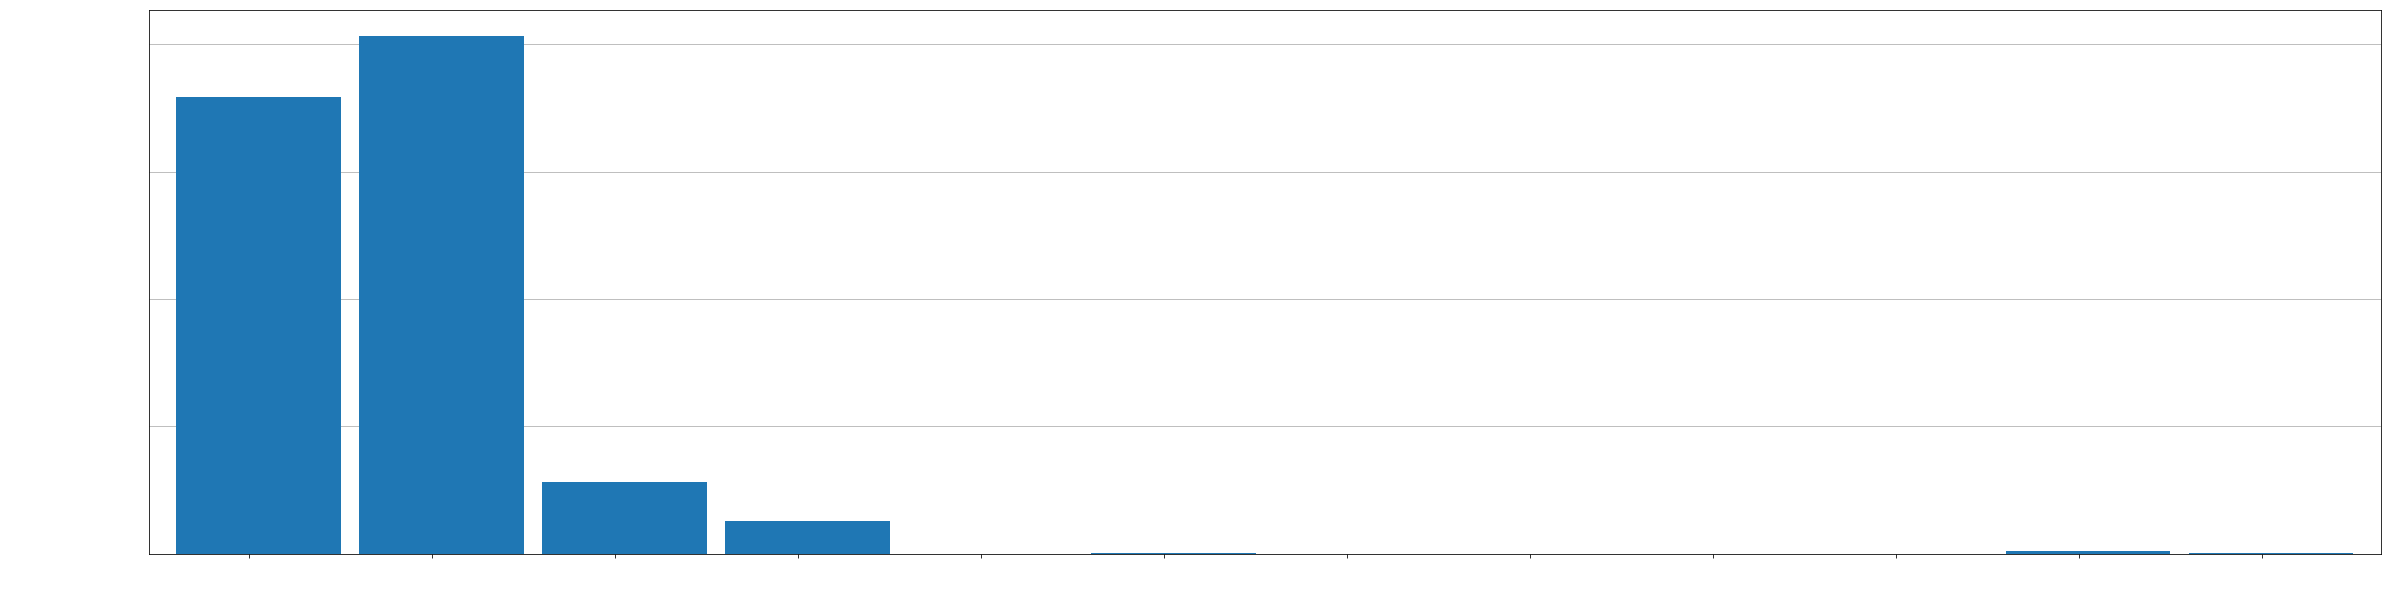

In [150]:
x = sorted(set(bad_restarts))
xx = numpy.arange(len(x))
y = [bad_restarts[d][0]/3600 for d in x]

width = .9
plots = []
fig, ax = plt.subplots(figsize=(40, 10))
#ax.set_title(title,color='white')
ax.set_xticks(xx-.05)
ax.set_xticklabels(x, color='white')
ax.get_yaxis().set_tick_params(colors='white')
#ax.set_xlabel('Month', labelpad=10, color='white', fontsize=44)
ax.set_ylabel('CPUhours', labelpad=10, color='white', fontsize=44)
ax.get_yaxis().grid(b=True, which='major')
ax.set_axisbelow(True)
bottom = numpy.zeros(len(x))
ax.bar(xx, y, width)
#labels = ax.get_xticklabels()
#plt.setp(labels, rotation=45, fontsize=15, horizontalalignment='right')
plt.xlim([-.6,len(xx)-.4])
#plt.ylim([0,80000])

In [54]:
pprint(bad_restarts)

defaultdict(<function make3list at 0x7f58dd982378>,
            {'2016-01': [96276662.0, 327921.0, 788973],
             '2016-02': [86434449.0, 219196.0, 609085],
             '2016-03': [9703920.0, 223991.0, 515360],
             '2016-04': [2124170.0, 64479.0, 140013],
             '2016-05': [2946023.0, 30459.0, 65319],
             '2016-06': [816747.0, 78149.0, 182820],
             '2016-07': [32723.0, 88010.0, 199266],
             '2016-08': [87191.0, 45228.0, 104621],
             '2016-09': [566820.0, 234691.0, 583183],
             '2016-10': [446730.0, 175150.0, 421102],
             '2016-11': [1310279.0, 154054.0, 357765],
             '2016-12': [300050.0, 156616.0, 353899]})


In [62]:
sum(good_completed[k][d][0] for k in good_completed for d in good_completed[k])/3600

18330170.678055555

In [63]:
sum(bad_all[k][d][0] for k in bad_all for d in bad_all[k])/3600

5190441.8672222225

In [212]:
good_completed['HOSTED_STANFORD']['2017-02-01'][0]/3600

1200.245